In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


2024-10-04 11:49:58.384561: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-04 11:49:58.395095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 11:49:58.406660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 11:49:58.410208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 11:49:58.418956: I tensorflow/core/platform/cpu_feature_guar

https://www.kaggle.com/datasets/doctrinek/catbreedsrefined-7k

In [3]:
import pathlib

data_dir = pathlib.Path('static/data')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

7000


In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7000 files belonging to 20 classes.
Using 5600 files for training.


I0000 00:00:1728058613.400552   16235 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 12:16:53.433150: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 7000 files belonging to 20 classes.
Using 1400 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Exotic Shorthair', 'Maine Coon', 'Manx', 'Norwegian Forest', 'Persian', 'Ragdoll', 'Russian Blue', 'Scottish Fold', 'Siamese', 'Sphynx', 'Turkish Angora']


2024-10-04 12:19:54.112417: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


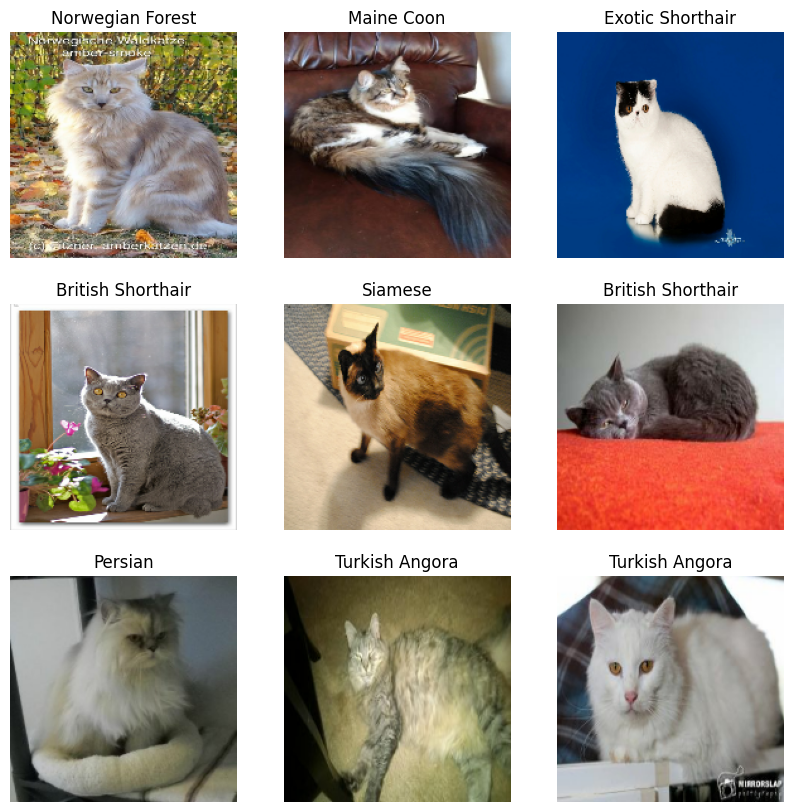

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [11]:
normalization_layer = layers.Rescaling(1./255)


In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.96035963


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


/home/dev/anaconda3/envs/nvidia/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [15]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,991,220 (15.23 MB)

 Trainable params: 3,991,220 (15.23 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.0823 - loss: 2.9842 - val_accuracy: 0.1471 - val_loss: 2.7880
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.1834 - loss: 2.6686 - val_accuracy: 0.2379 - val_loss: 2.5423
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.2849 - loss: 2.2955 - val_accuracy: 0.2486 - val_loss: 2.5091
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.4601 - loss: 1.7578 - val_accuracy: 0.2364 - val_loss: 2.6702
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.6569 - loss: 1.1065 - val_accuracy: 0.2421 - val_loss: 3.3802
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.8328 - loss: 0.5757 - val_accuracy: 0.2264 - val_loss: 4.2076
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9330 - loss: 0.2593 - val_accuracy: 0.2200 - val_loss: 5.4779
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9692 - loss: 0.1321 - 

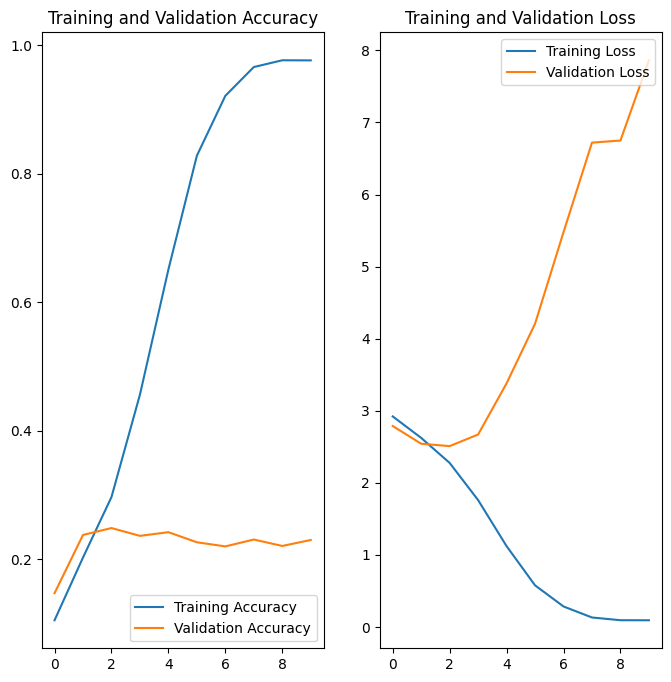

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [22]:

sunflower_path = pathlib.Path('static/testing/Untitled.jpeg')

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
This image most likely belongs to Norwegian Forest with a 100.00 percent confidence.


In [21]:
model.save('car_classifier.keras')